### HEC Data Challenge 2023:
#### Case 1, Équipe 7
##### Alloprof

In [1]:
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
import scipy as sc
from scipy import stats
import copy
from collections import defaultdict, OrderedDict
from heapq import *
import copy
from scipy import linalg
from mpl_toolkits.mplot3d import Axes3D
# from prophet import Prophet
from datetime import datetime


In [2]:
def kmeans(U,k):
    (n,m)=U.shape
    tmp=np.random.choice(range(n), k, replace=False)
    C=np.zeros((k, m))#k points a m coordonnees
    for i in np.arange(k):
        C[i]=U[tmp[i]] #on rentre les coordonnes des centres aleatoires de clusters dans C
    C_old=np.zeros(C.shape)#on initialise a 0 puis on actualise a chaque boucle
    clusters = np.zeros(n) #clusters[i] indique l'indice du cluster dans lequel doit aller le i-eme point
    diff = dist2(C, C_old, None)#on tourne tant que les centres de clusters changent et donc la diff est non nulle
    while diff != 0:
        for i in range(n):
            distances=np.zeros(k)
            for j in range(k):
                distances[j]= dist2(U[i], C[j], None)#distances entre le ieme point de U et chaque centre de cluster, distances a k valeurs
            tmp=np.argmin(distances)#l'indice du centre le plus proche
            clusters[i] = tmp #le i-eme point va dans le temp-ieme cluster
        C_old=copy.deepcopy(C)#on stocke les anciens centres pour pouvoir comparer avec les nouveaux
        for i in range(k):
            points = [U[j] for j in range(n) if clusters[j] == i]
            C[i] = np.mean(points, axis=0)#stocke les coordonnes du centre du cluster i
        diff = dist2(C, C_old, None)
    return(C, clusters)

In [3]:
com=pd.read_csv('details_communications-20230301.csv', delimiter=',')
# alltype=([('f0','str'),('f1','date'),('f2','str'),('f3','str'),('f4','str'), ('f5', ''), ('f6', 'f8'),('f7','f8'),('f8','f8'),('f9','i8'),('f10','i8')])
# com=np.genfromtxt(completename,delimiter=",",dtype=alltype,usecols=[0,1,2,3,4,5,6,7,8,9,10], names=True)
# com=np.array(times, dtype=object)
# com.head()
com = com.query("Date >= '2021-08-1'")
com['Date'] = pd.to_datetime(com['Date'])
com['day_of_week'] = com['Date'].dt.dayofweek
com['Week_Number'] = com['Date'].dt.isocalendar().week
com["month"] = com["Date"].dt.month
com["Year"] = com["Date"].dt.year
com["MY"]= com['Date'].dt.strftime('%Y-%m')
com['heure'] = com.Time.str[0:2]
com.head()

,Conversation_ID,Date,Time,Agent,Service,Direction,Langue,Niveau,Matiere,temps_comm,temps_attente,day_of_week,Week_Number,month,Year,MY,heure
6402,85395466-e939-5f6f-a135-0eac412ca01f,2021-08-12,08:56,VvFRUkuGXkm7BFLOe+/Fkirw5D8=,Call,direct,fr,NaN,NaN,5,NaN,3,32,8,2021,2021-08,08
6403,904ef45f-45b9-5471-9966-1a856689bbc6,2021-08-12,20:00,VvFRUkuGXkm7BFLOe+/Fkirw5D8=,SMS,rappel,fr,NaN,NaN,14,3.0,3,32,8,2021,2021-08,20
6404,2dd090fd-e56e-523f-bf8f-ad1b57b9ad2a,2021-08-12,08:52,VvFRUkuGXkm7BFLOe+/Fkirw5D8=,Call,rappel,fr,NaN,NaN,6,3.0,3,32,8,2021,2021-08,08
6405,e8d8ceca-f865-5701-ac7a-ff7a9a531d2e,2021-08-24,16:40,VvFRUkuGXkm7BFLOe+/Fkirw5D8=,Chat,direct,fr,NaN,NaN,3,6.0,1,34,8,2021,2021-08,16
6406,cc52e125-c19e-56f6-9737-932e19b19161,2021-08-25,07:36,Px+R4MtCavrfnecAZkTmz8y5OPU=,Chat,direct,fr,NaN,NaN,1,59.0,2,34,8,2021,2021-08,07


In [4]:
### Numbers of conversations per day 
a=com.groupby("day_of_week").size().values
new=com.drop_duplicates(subset="day_of_week").assign(Count=a)
com.sort_values(by=['day_of_week'])
new.sort_values(by=['day_of_week'])
# new['row_number'] = new.reset_index().index
# new.head()
# com.head()

,Conversation_ID,Date,Time,Agent,Service,Direction,Langue,Niveau,Matiere,temps_comm,temps_attente,day_of_week,Week_Number,month,Year,MY,heure,Count
6472,f2d662be-7238-5ddc-974d-aadd6fddafbd,2021-08-30,10:23,d6PU3e+xIUCrW2EcrrHMSOJl4uI=,Call,direct,fr,NaN,NaN,6,NaN,0,35,8,2021,2021-08,10,38
6405,e8d8ceca-f865-5701-ac7a-ff7a9a531d2e,2021-08-24,16:40,VvFRUkuGXkm7BFLOe+/Fkirw5D8=,Chat,direct,fr,NaN,NaN,3,6.0,1,34,8,2021,2021-08,16,16906
6406,cc52e125-c19e-56f6-9737-932e19b19161,2021-08-25,07:36,Px+R4MtCavrfnecAZkTmz8y5OPU=,Chat,direct,fr,NaN,NaN,1,59.0,2,34,8,2021,2021-08,07,15903
6402,85395466-e939-5f6f-a135-0eac412ca01f,2021-08-12,08:56,VvFRUkuGXkm7BFLOe+/Fkirw5D8=,Call,direct,fr,NaN,NaN,5,NaN,3,32,8,2021,2021-08,08,15334
6419,e940e227-21aa-5548-8c54-df30477a2a1c,2021-08-27,07:29,VvFRUkuGXkm7BFLOe+/Fkirw5D8=,SMS,direct,fr,secondaire,education_financiere,2,4.0,4,34,8,2021,2021-08,07,12040
10958,3badb8c2-6e1d-5a8e-a14a-65e33e87e758,2021-10-02,10:20,winQQQwwj13Z66ptw4BqTmld9Cw=,Call,direct,fr,NaN,NaN,101,NaN,5,39,10,2021,2021-10,10,11762
6427,2b7607ae-1cfd-5e82-919b-7310261b250d,2021-08-29,16:12,VvFRUkuGXkm7BFLOe+/Fkirw5D8=,Call,direct,fr,NaN,NaN,4,NaN,6,34,8,2021,2021-08,16,119


In [5]:
# new.tail()

<AxesSubplot:xlabel='Year,day_of_week'>

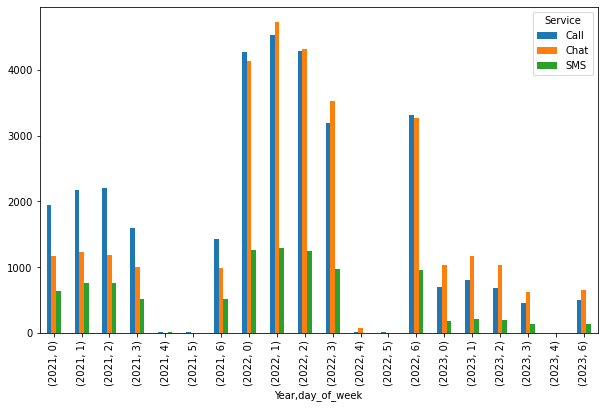

In [6]:
fig, axs = plt.subplots(figsize=(10, 6))
com['counter']=1
new=com.groupby(["day_of_week",'Year','Service'])['counter'].sum().reset_index(name ='Sum')
com_pivot = pd.pivot_table(new, 
                          values="Sum", 
                          index=['Year',"day_of_week"], 
                          columns="Service")

com_pivot.plot.bar(ax=axs)
# com_pivot.plot(ax=axs)

<AxesSubplot:xlabel='Week_Number'>

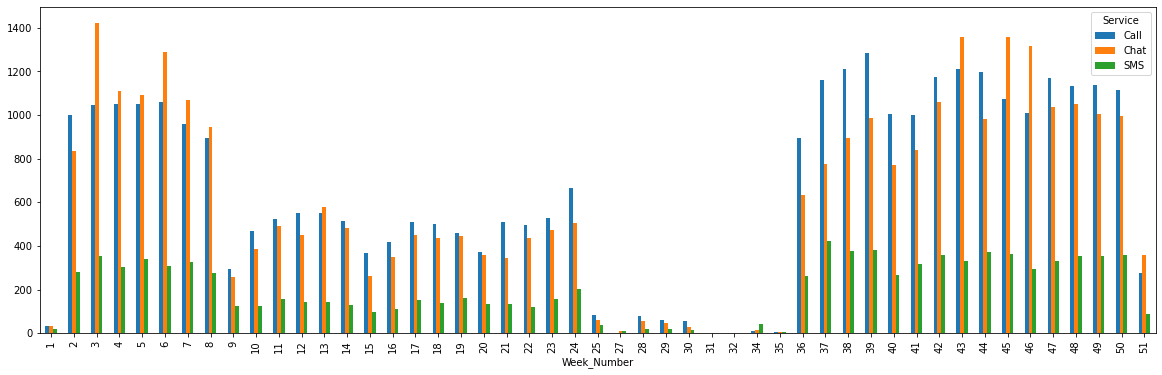

In [7]:
# Weekly over years
# a=com.groupby("Week_Number").size().values
# new=com.drop_duplicates(subset="Week_Number").assign(Count=a)
# # new.sort_values(by=['Week_number'])
# com.head()
# new.tail()
# new.plot(x='Week_Number', y='Count', kind='bar')
# plt.show()

fig, axs = plt.subplots(figsize=(20, 6))
com['counter']=1
new=com.groupby(["Week_Number",'Service'])['counter'].sum().reset_index(name ='Sum')
com_pivot = pd.pivot_table(new, 
                          values="Sum", 
                          index="Week_Number", 
                          columns="Service")

com_pivot.plot.bar(ax=axs)

<AxesSubplot:xlabel='MY'>

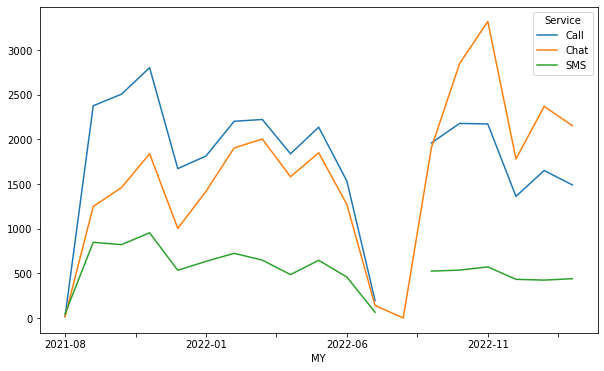

In [8]:
# Monthly over years
fig, axs = plt.subplots(figsize=(10, 6))
train = com[com.Date < pd.to_datetime("2022-12-15", format='%Y-%m-%d')]
test = com[com.Date > pd.to_datetime("2022-12-15", format='%Y-%m-%d')]
com['counter']=1
new=com.groupby(["MY",'Service'])['counter'].sum().reset_index(name ='Sum')
com_pivot = pd.pivot_table(new, 
                          values="Sum", 
                          index="MY",
                          columns="Service")

# com_pivot.plot.bar(ax=axs)
com_pivot.plot(ax=axs)

<AxesSubplot:xlabel='Year,month'>

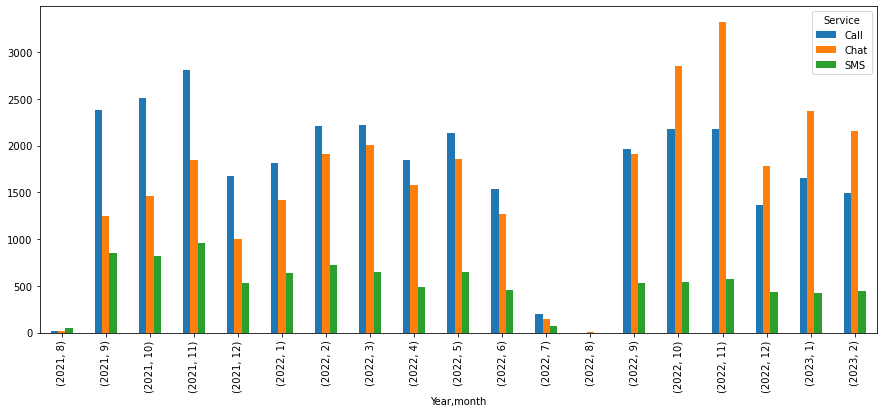

In [9]:
# Monthly over years
fig, axs = plt.subplots(figsize=(15, 6))
com['counter']=1
new=com.groupby(["month",'Service','Year'])['counter'].sum().reset_index(name ='Sum')
com_pivot = pd.pivot_table(new, 
                          values="Sum", 
                          index=['Year','month'], 
                          columns="Service")

com_pivot.plot.bar(ax=axs)

# a=com.groupby("month").size().values
# new=com.drop_duplicates(subset="month").assign(Count=a)
# new.sort_values(by=['month'])
# com.head()
# new.tail()
# new.plot(x='month', y='Count', kind='bar')
# plt.show()

<AxesSubplot:xlabel='heure'>

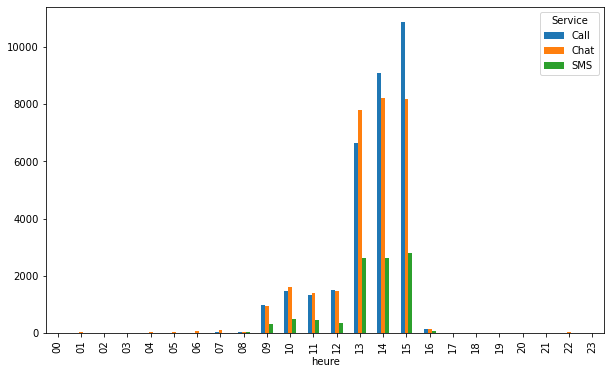

In [10]:
fig, axs = plt.subplots(figsize=(10, 6))
com['counter']=1
new=com.groupby(["heure",'Service'])['counter'].sum().reset_index(name ='Sum')
com_pivot = pd.pivot_table(new, 
                          values="Sum", 
                          index="heure", 
                          columns="Service")

com_pivot.plot.bar(ax=axs)

<AxesSubplot:xlabel='heure'>

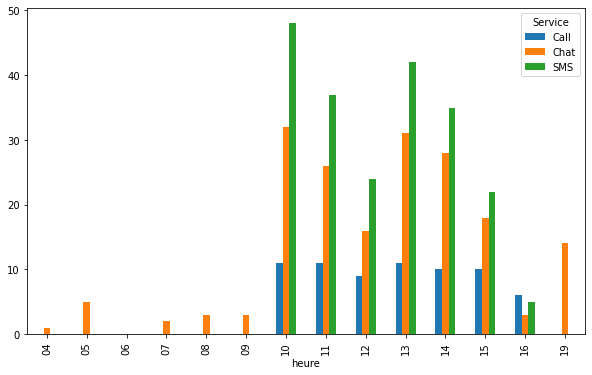

In [11]:
fig, axs = plt.subplots(figsize=(10, 6))
com['counter']=1
com = com.query("Date >= '2022-08-1'")
new=com.groupby(["heure",'Service'])['temps_comm'].mean().reset_index(name ='Sum')
new['Sum']=new['Sum']//60
com_pivot = pd.pivot_table(new, 
                          values="Sum", 
                          index="heure", 
                          columns="Service")

com_pivot.plot.bar(ax=axs)

<AxesSubplot:xlabel='month,Matiere'>

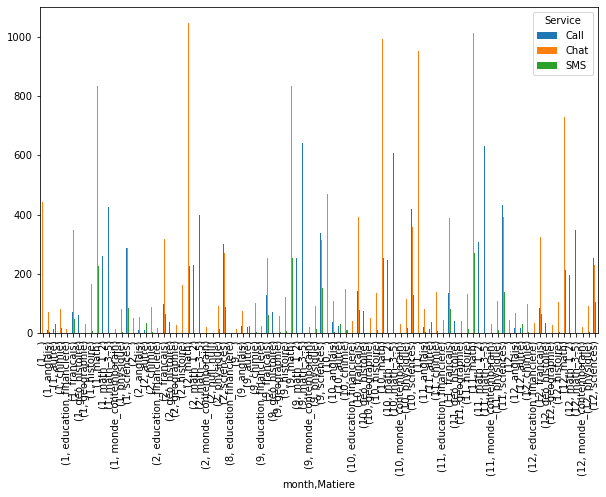

In [12]:
fig, axs = plt.subplots(figsize=(10, 6))
com['counter']=1
new=com.groupby(["month",'Service','Matiere'])['counter'].sum().reset_index(name ='Sum')
com_pivot = pd.pivot_table(new, 
                          values="Sum", 
                          index=["month", 'Matiere'], 
                          columns="Service")

com_pivot.plot.bar(ax=axs)

<AxesSubplot:xlabel='Matiere'>

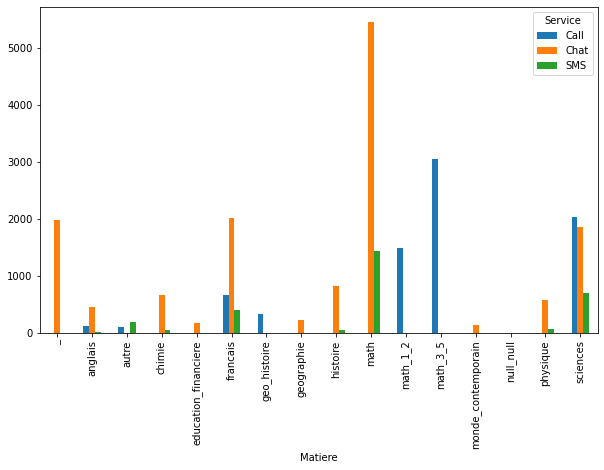

In [13]:
fig, axs = plt.subplots(figsize=(10, 6))
com['counter']=1
new=com.groupby(['Matiere','Service'])['counter'].sum().reset_index(name ='Sum')
com_pivot = pd.pivot_table(new, 
                          values="Sum", 
                          index='Matiere', 
                          columns="Service")

com_pivot.plot.bar(ax=axs)

<AxesSubplot:xlabel='Matiere'>

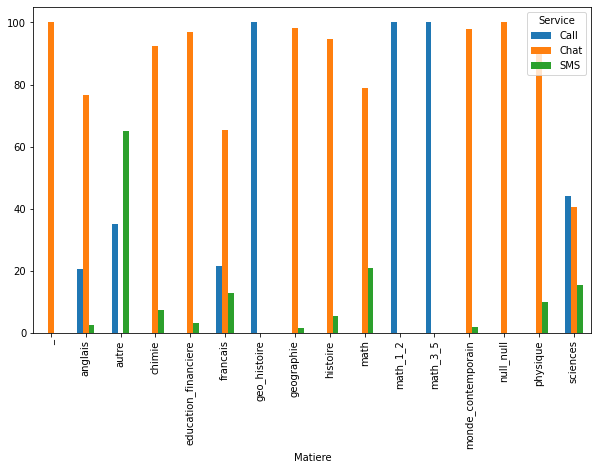

In [14]:
fig, axs = plt.subplots(figsize=(10, 6))
com['counter']=1
com= com.groupby(['Matiere', 'Service']).agg({'counter': 'sum'})
Matiere = com.groupby(['Matiere']).agg({'counter': 'sum'})
new=com.div(Matiere, level='Matiere') * 100
com_pivot = pd.pivot_table(new, 
                          values="counter", 
                          index='Matiere', 
                          columns="Service")

com_pivot.plot.bar(ax=axs)

In [15]:
h=pd.read_csv('historique_communications-20230301.csv', delimiter=',')
h.head()

,Date,Service,Direction,Langue,Record_count
0,2017-11-02,Chat,direct,fr,66
1,2017-11-02,Call,direct,fr,235
2,2017-11-03,Chat,direct,fr,3
3,2017-11-06,Chat,direct,fr,34
4,2017-11-06,Call,direct,fr,257


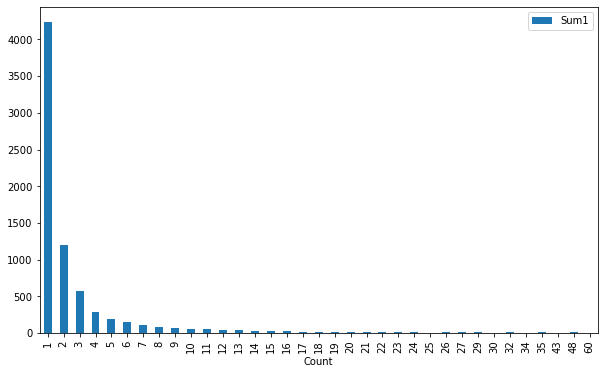

In [16]:
fig, axs = plt.subplots(figsize=(10, 6))
users=pd.read_csv('users-20230301.csv', delimiter=',')
users.head()
users['counter']=1

a=users.groupby("user").size().values
new=users.drop_duplicates(subset="user").assign(Count=a)
# new=users.groupby(["user"])['counter'].sum().reset_index(name ='Sum')
new['counter']=1
new1=new.groupby(["Count"])['counter'].sum().reset_index(name ='Sum1')
new1= new1.query("Sum1>5")
new1.plot(x='Count', y='Sum1', kind='bar', ax=axs)
plt.show()

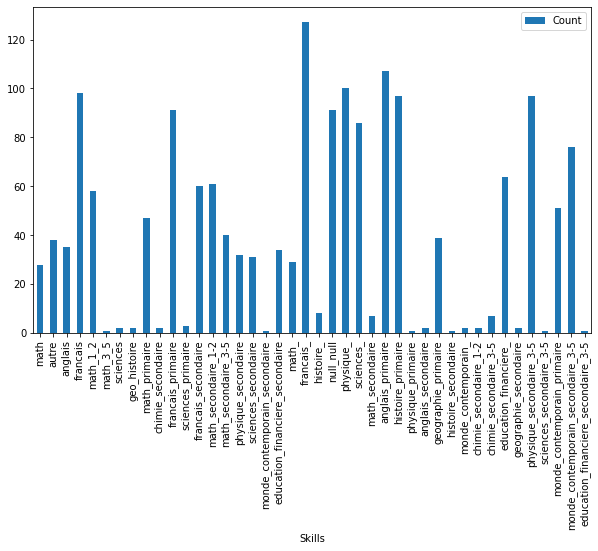

In [17]:
fig, axs = plt.subplots(figsize=(10, 6))
agents=pd.read_csv('agents-20230301.csv', delimiter=',')
agents['counter']=1

a=agents.groupby("Skills").size().values
new=agents.drop_duplicates(subset="Skills").assign(Count=a)
new.head()
new.plot(x='Skills', y='Count', kind='bar',ax=axs)
plt.show()


In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")
import datetime # manipulating date formats
import itertools
import time

In [19]:

com=pd.read_csv('details_communications-20230301.csv', delimiter=',')
# alltype=([('f0','str'),('f1','date'),('f2','str'),('f3','str'),('f4','str'), ('f5', ''), ('f6', 'f8'),('f7','f8'),('f8','f8'),('f9','i8'),('f10','i8')])
# com=np.genfromtxt(completename,delimiter=",",dtype=alltype,usecols=[0,1,2,3,4,5,6,7,8,9,10], names=True)
# com=np.array(times, dtype=object)
# com.head()
com = com.query("Date >= '2021-08-01'")
com['Date'] = pd.to_datetime(com['Date'])
com['day_of_week'] = com['Date'].dt.dayofweek
com['Week_Number'] = com['Date'].dt.isocalendar().week
com["month"] = com["Date"].dt.month
com["Year"] = com["Date"].dt.year
com["MY"]= com['Date'].dt.strftime('%Y-%m')
com['heure'] = com.Time.str[0:2]
com.head()

train_end = '2022-12-22'
test_end = '2023-02-28'
demo_start = '2022-12-25'

test = com[com.Date > pd.to_datetime("2022-12-31", format='%Y-%m-%d')]
test['counter']=1

test=test.groupby(["Date",'Service'])['counter'].sum().reset_index(name ='Sum')

Service,Date,Sum
0,2021-08-02,8.0
1,2021-08-04,8.0
2,2021-08-05,18.0
3,2021-08-12,2.0
4,2021-08-24,1.0


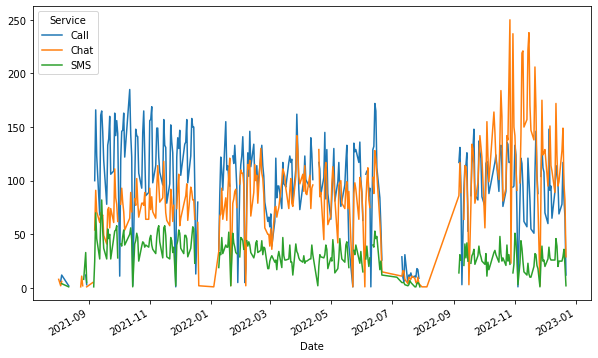

In [73]:

train= com[com.Date < pd.to_datetime("2022-12-31", format='%Y-%m-%d')]
train['counter']=1
train=train.groupby(["Date",'Service'])['counter'].sum().reset_index(name ='Sum')

com_pivot = pd.pivot_table(train, 
                          values="Sum", 
                          index="Date",
                          columns="Service")
# com_pivot.head()

#Image 
fig, axs = plt.subplots(figsize=(10, 6))
# com_pivot.plot.bar(ax=axs)
com_pivot.plot(ax=axs)

##Training set 
train = com_pivot.reset_index()
train.set_index('Date')
train['Call']=train['Call'].fillna(0)
train['Chat']=train['Chat'].fillna(0)
train['SMS']=train['SMS'].fillna(0)
train['Sum']=train.iloc[:,1:3].sum(axis=1)
train=train.loc[:,['Date','Sum']]
train.head()

In [76]:
test = com[com.Date > pd.to_datetime("2022-12-31", format='%Y-%m-%d')]
test['counter']=1
test=test.groupby(["Date",'Service'])['counter'].sum().reset_index(name ='Sum')
com_pivot_test = pd.pivot_table(test, 
                          values="Sum", 
                          index="Date",
                          columns="Service")
# com_pivot.head()

# com_pivot_test.plot.bar(ax=axs)
com_pivot.plot(ax=axs)
test = com_pivot_test.reset_index()
test.set_index('Date')
test['Call']=test['Call'].fillna(0)
test['Chat']=test['Chat'].fillna(0)
test['SMS']=test['SMS'].fillna(0)
test['Sum']=test.iloc[:,1:3].sum(axis=1)
test=test.loc[:,['Date','Sum']]
test.tail()


Service,Date,Sum
32,2023-02-20,261.0
33,2023-02-21,307.0
34,2023-02-22,243.0
35,2023-02-23,130.0
36,2023-02-28,1.0


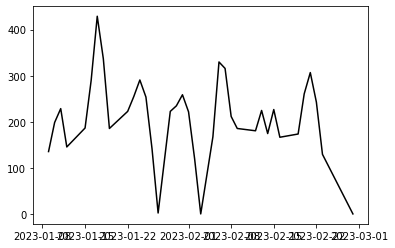

In [78]:
# plt.plot(test.index, train['Call'], )
plt.plot(test['Date'], test['Sum'], color='Black', label = 'Test data')

# Autoregressive Integrated Moving Average (ARIMA) regression model:    

In [79]:
from statsmodels.tsa.arima.model import ARIMA

RMSE:  96.84996538326634


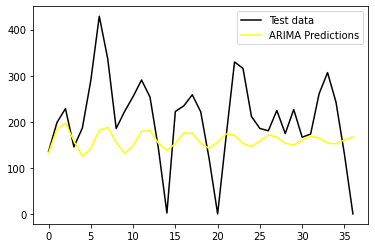

In [81]:
ARIMAmodel = ARIMA(y, order = (2, 1, 3))
ARIMAmodel = ARIMAmodel.fit()
y = train['Sum']
y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(test['Sum'], color='Black', label = 'Test data')
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()

import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["Sum"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

# SARIMAX regression model: 

Results of Dickey-Fuller Test:
Test Statistic                  -4.158
p-value                          0.001
#Lags Used                       8.000
Number of Observations Used    301.000
Critical Value (1%)             -3.452
Critical Value (5%)             -2.871
Critical Value (10%)            -2.572
dtype: float64


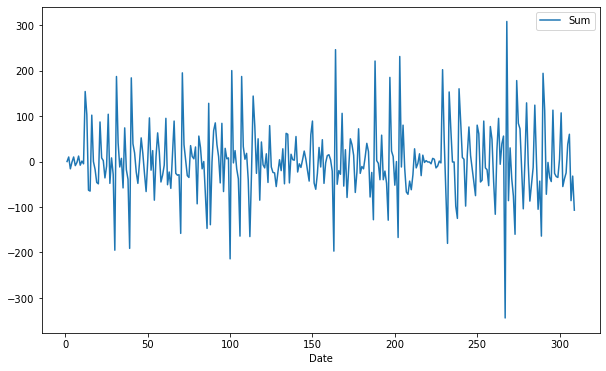

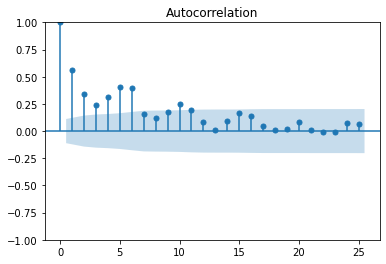

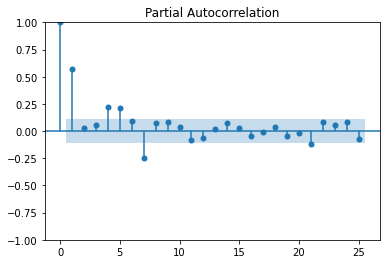

In [88]:
# train= train.sum(axis=1).to_frame(name='Sum')
# train.index.rename('Date',inplace=False)
# train.head()
# test= test.sum(axis=1).to_frame(name='Sum')
# test.index.rename('Date',inplace=True)
# test.head()

def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=7*4, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))
test_stationarity(train.Sum)

def invert_diff(series, first_element_before):
    cumsum = series.cumsum()
    return cumsum.fillna(0) + first_element_original


diffed = diff(train,seasonal_periods=7)
diffed.plot(figsize=(10,6))

acf = plot_acf(train)
pacf = plot_pacf(train)

def sarimax(ts,exo,all_param):
    results = []
    for param in all_param:
        try:
            mod = SARIMAX(ts,
                          exog = exo,
                          order=param[0],
                          seasonal_order=param[1])
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
        except Exception as e:
            print(e)
            continue
            
    return results

In [96]:
import holidays
begin = '2021-08-01'
abv = '2023-02-28'
hol = pd.to_datetime(holidays.CountryHoliday('Canada')[begin:abv])
hol=hol.strftime('%Y-%m-%d')


exo_train = train.copy()
exo_train["holidays"] = 0
exo_test = test.copy()
exo_test["holidays"] = 0
exo_test.head()
# exo_train.loc[hol]=1

# exo_test.drop(["Sum"],axis=1,inplace=True)
# exo_train.drop(["Sum"],axis=1,inplace=True)

# # exo_train,exo_test = exo[:train_end],exo[train_end:abv]
print(exo_test)
print(exo_train)

        Sum  holidays
Date                 
0     136.0         0
1     199.0         0
2     229.0         0
3     146.0         0
4     187.0         0
5     290.0         0
6     429.0         0
7     337.0         0
8     186.0         0
9     223.0         0
10    255.0         0
11    291.0         0
12    254.0         0
13    142.0         0
14      3.0         0
15    223.0         0
16    235.0         0
17    259.0         0
18    222.0         0
19    120.0         0
20      1.0         0
21    168.0         0
22    330.0         0
23    316.0         0
24    212.0         0
25    186.0         0
26    181.0         0
27    225.0         0
28    175.0         0
29    227.0         0
30    167.0         0
31    174.0         0
32    261.0         0
33    307.0         0
34    243.0         0
35    130.0         0
36      1.0         0
        Sum  holidays
Date                 
0       8.0         0
1       8.0         0
2      18.0         0
3       2.0         0
4       1.

In [91]:
# set parameter range
p,d,q = range(0,3),[1],range(0,3)
P,D,Q,s = range(0,3),[1],range(0,3),[7]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))

all_res = sarimax(train,exo_train,all_param)

Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 7) - AIC:3774.2
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 7) - AIC:3525.48
Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 7) - AIC:3507.78
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 7) - AIC:3643.41
Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 7) - AIC:3509.68
Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 7) - AIC:3508.37
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 7) - AIC:3600.2
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 7) - AIC:3510.51
Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 7) - AIC:3510.06
Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 7) - AIC:3697.93
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 7) - AIC:3474.9
Tried out SARIMAX(0, 1, 1)x(0, 1, 2, 7) - AIC:3465.64
Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 7) - AIC:3590.5
Tried out SARIMAX(0, 1, 1)x(1, 1, 1, 7) - AIC:3466.66
Tried out SARIMAX(0, 1, 1)x(1, 1, 2, 7) - AIC:3466.52
Tried out SARIMAX(0, 1, 1)x(2, 1, 0, 7) - AIC:3549.71
Tried out SARIMAX(0, 1, 1)x(2, 1, 1, 7) - AIC:3467.88
Tried out SARIMAX(0, 1, 1)x(2, 1, 2, 7) - AIC:3469.06
Tried out SARIMAX(0, 1, 2)x(0, 1

In [95]:
test.head()

,Sum
Date,
0,136.0
1,199.0
2,229.0
3,146.0
4,187.0


[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x000002010F8CC790>, 3431.1137144073887, ((2, 1, 2), (0, 1, 2, 7))), (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x000002011532C910>, 3432.700104388314, ((2, 1, 2), (1, 1, 2, 7))), (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x000002011532CB50>, 3432.9761108143657, ((2, 1, 2), (1, 1, 1, 7))), (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x00000201177C7400>, 3434.314761931791, ((2, 1, 2), (2, 1, 1, 7))), (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x0000020181E46400>, 3436.274990503223, ((2, 1, 2), (2, 1, 2, 7)))]


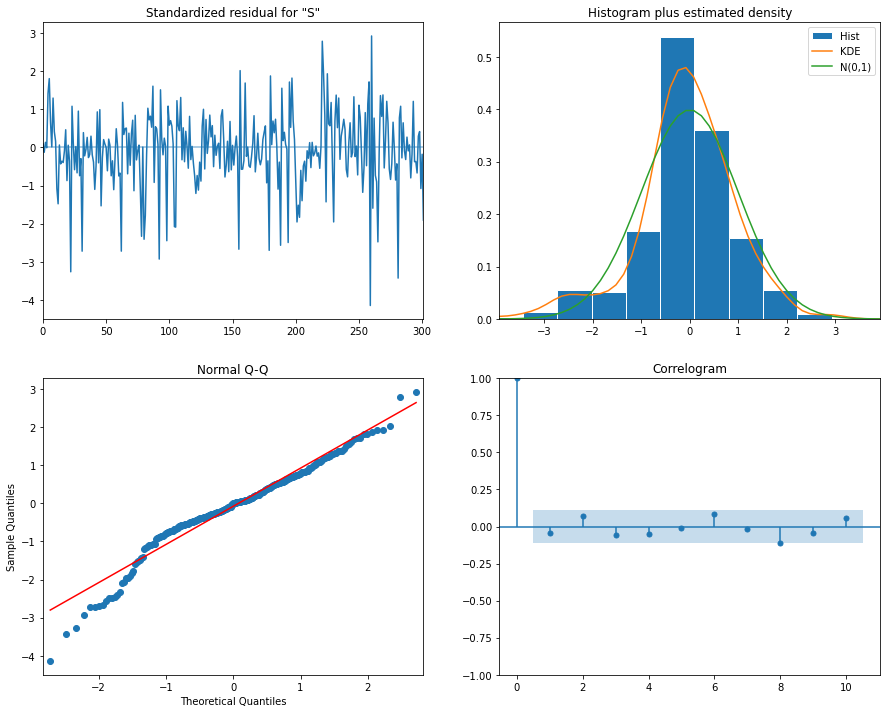

Ljung-box p-values:
[0.43868781 0.32207466 0.35986772 0.39546744 0.53354652 0.39549093
 0.49982772 0.26515003 0.30944815 0.30877934 0.38272016 0.44309726
 0.43358778 0.51146467]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               Sum   No. Observations:                  310
Model:             SARIMAX(2, 1, 2)x(0, 1, 2, 7)   Log Likelihood               -1707.557
Date:                           Fri, 17 Mar 2023   AIC                           3431.114
Time:                                   09:31:30   BIC                           3460.797
Sample:                                        0   HQIC                          3442.990
                                           - 310                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holidays            0   1.79e+05          0      1.000   -3.52e+05    3.52e+05
ar.L1          0.9785      0.145      6.764      0.000       0.695       1.262
ar.L2         -0.5197      0.079     -6.573      0.000      -0.675      -0.365
ma.L1         -1.4078      0.150     -9.384      0.000      -1.702      -1.114
ma.L2          0.6181      0.124      4.980      0.000       0.375       0.861
ma.S.L7       -1.2879      0.071    -18.093      0.000      -1.427      -1.148
ma.S.L14       0.3161      0.072      4.374      0.000       0.174       0.458
sigma2      4382.4128    278.723     15.723      0.000    3836.126    4928.700
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):                61.17
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.65
Prob(H) (two-sided):                  0.24   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
all_res.sort(key=lambda x: x[1])
print(all_res[:5])

res = all_res[0][0]
res.plot_diagnostics(figsize=(15, 12))

plt.show()
print("Ljung-box p-values:\n" + str(res.test_serial_correlation(method='ljungbox')[0][1]))
res.summary()

In [94]:
pred_test = res.get_prediction(start=train_end,end=test_end,exog=test)
err = 'Mean absolute percentage error: %.2f'% MAPE(test, pred_test.predicted_mean) + \
'\nRoot mean squared error: %.2f'% sqrt(MSE(test, pred_test.predicted_mean))

pred = res.get_prediction(start=begin,end=test_end,exog=exo_test)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Energy consumption', ylabel='kWh')

ts.plot(ax=ax, style = 'o')
pred.predicted_mean.plot(ax=ax, style='o')
ci = pred_ci.loc[demo_start:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
legend = ax.legend(["Train Set Observed","Test Set Observed", "Forecast"])

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [ ]:
pred_test = res.get_prediction(start=train_end,end=test_end,exog=exo_test)
# The root mean squared error
err = 'Mean absolute percentage error: %.2f'% MAPE(test, pred_test.predicted_mean) + \
'\nRoot mean squared error: %.2f'% sqrt(MSE(test, pred_test.predicted_mean))

pred = res.get_prediction(start=demo_start,end=test_end,exog=exo_test)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Energy consumption', ylabel='kWh')

train[demo_start:].plot(ax=ax)
test.plot(ax=ax)
pred.predicted_mean.plot(ax=ax)
ci = pred_ci.loc[demo_start:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
legend = ax.legend(["Train Set Observed","Test Set Observed", "Forecast"])
ax.grid(True)


In [ ]:
train.head()
test.head()
y = train['Call']
SARIMAXmodel = SARIMAX(y, order = (2, 1, 2), seasonal_order=(1,1,1,7))
SARIMAXmodel = SARIMAXmodel.fit()
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.1) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

sarma_rmse = np.sqrt(mean_squared_error(test["Call"].values, y_pred_df["Predictions"]))
print("RMSE: ",sarma_rmse)
plt.plot(test['Call'], color='Black', label = 'Test data')
plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
plt.legend()

In [ ]:
test.columns